### Penjelasan
Cell ini merupakan bagian pembuka yang menjelaskan tujuan utama notebook, yaitu optimasi portofolio saham menggunakan algoritma genetika.

# 🧬 Optimasi Portofolio dengan Genetic Algorithm

**Deskripsi singkat:**  
Notebook ini melakukan optimasi proporsi investasi antara berbagai instrumen keuangan — seperti **Saham Indonesia (misal: ADRO, BBCA, ANTM, PTBA)**, **Crypto (misal: BTC, ETH, BNB)**, maupun **Reksadana** — menggunakan *Genetic Algorithm (GA)*.  

Program akan mencari kombinasi bobot portofolio terbaik untuk memaksimalkan *return* dengan risiko minimal berdasarkan parameter *risk aversion*.  
Hasil meliputi:
- Bobot portofolio optimal  
- Ekspektasi *return* dan risiko  
- Evolusi *fitness* selama generasi  
- Visualisasi dan hasil akhir yang diekspor ke folder `outputs/`

### 1. Impor Library
Kumpulkan semua library yang dibutuhkan..

In [154]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
# import warnings
# warnings.filterwarnings('ignore')

import math

### 2. Konfigurasi Parameter
Cell ini mendefinisikan parameter awal untuk algoritma genetika seperti daftar saham yang akan dioptimasi,  
tanggal mulai data, ukuran populasi, jumlah generasi, tingkat aversi risiko, dan seed acak untuk reproduktibilitas.  
Parameter ini berperan sebagai pengaturan awal sebelum proses evolusi dimulai.

In [155]:
TICKERS = ['ADRO.JK', 'BBCA.JK', 'ANTM.JK', 'BBNI.JK', 'PTBA.JK']
START_DATE = '2022-01-01' # mulai tarik data
END_DATE = None # sampai hari ini
POP_SIZE = 100
GENERATIONS = 300
RISK_AVERSION = 0.5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### 3. Persiapan Folder Output  
Sebelum data hasil olahan disimpan, kita perlu memastikan folder output tersedia.
Langkah ini membuat dua folder:
1. 'data/'  → menyimpan data harga, return harian, dan matriks kovarians
2. 'outputs/' → menyimpan hasil visualisasi seperti grafik fitness, pie chart, dll.

In [156]:

OUTPUT_FOLDER = 'data'
OUTPUT_IMG_DIR = 'outputs'

try:
    # Pastikan folder data dan output gambar tersedia
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
    print(f"📁 Folder '{OUTPUT_FOLDER}/' dan '{OUTPUT_IMG_DIR}/' dipastikan ada.")
except Exception as e:
    print(f"❌ Gagal membuat folder output: {e}")
    OUTPUT_FOLDER = ''
    OUTPUT_IMG_DIR = ''


📁 Folder 'data/' dan 'outputs/' dipastikan ada.


### 4. Pengunduhan Data Saham  
Cell ini mengunduh data harga saham dari Yahoo Finance menggunakan daftar `TICKERS`.  
Data akan berisi berbagai kolom (misalnya Open, High, Low, Close, Adj Close), tergantung struktur sumber.

In [157]:
raw_data = yf.download(TICKERS, start=START_DATE, end=END_DATE, progress=False)


C:\Users\wahyu\AppData\Local\Temp\ipykernel_11444\1049450133.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(TICKERS, start=START_DATE, end=END_DATE, progress=False)


### 5. Deteksi Otomatis Struktur Kolom  
Karena format data Yahoo Finance bisa berubah (kadang `MultiIndex`, kadang tunggal),  
kode ini melakukan deteksi otomatis untuk mengambil kolom harga penutupan (Close / Adj Close).  
Jika struktur masih bertingkat, maka kolom diturunkan menjadi single-level untuk kemudahan analisis.


In [158]:
# Memeriksa apakah data memiliki MultiIndex pada kolom
if isinstance(raw_data.columns, pd.MultiIndex):
    # cari kolom yang mengandung 'close' (case-insensitive)
    close_cols = [col for col in raw_data.columns if 'close' in str(col).lower()]
    if len(close_cols) == 0:
        raise ValueError(f"Tidak ditemukan kolom harga penutupan pada data: {raw_data.columns[:5]}")
    data = raw_data.loc[:, close_cols]
    # Jika hasil masih multi-index, turunkan jadi single-level
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [col[-1] for col in data.columns]
else:
    # struktur normal (tanpa MultiIndex)
    if 'Adj Close' in raw_data.columns:
        data = raw_data['Adj Close']
    elif 'Close' in raw_data.columns:
        data = raw_data['Close']
    else:
        raise ValueError(f"Tidak ditemukan kolom 'Adj Close' maupun 'Close'. Kolom yang ada: {list(raw_data.columns)}")


### 5. Pembersihan Data dan Perhitungan Return  
Tahap ini memastikan data bersih dari nilai kosong (`NaN`),  
lalu menghitung *return harian* dan mengonversinya ke bentuk tahunan  
untuk digunakan dalam perhitungan *fitness function* pada algoritma genetika.


In [159]:
# Pastikan tidak ada missing data
data = data.dropna()
returns_daily = data.pct_change().dropna()

# Hitung return dan kovarians tahunan
mean_returns = returns_daily.mean() * 252
cov_matrix = returns_daily.cov() * 252

### 6. Ekspor Data Hasil Pra-pemrosesan  
Setelah data siap, tahap berikutnya mengekspor hasilnya ke dalam tiga file:  
1. **Data harga penutupan saham**  
2. **Data return harian**  
3. **Data matriks kovarians**  

Semua file disimpan ke folder `data` agar bisa digunakan kembali tanpa mengunduh ulang.


In [160]:

# 1. Ekspor data harga penutupan (DataFrame 'data')
file_path_harga = os.path.join(OUTPUT_FOLDER, 'harga_penutupan_saham.csv')
try:
    data.to_csv(file_path_harga)
    print(f"Sukses: Data harga penutupan diekspor ke '{file_path_harga}'")
except Exception as e:
    print(f"Gagal mengekspor harga penutupan: {e}")

# 2. Ekspor data return harian (DataFrame 'returns_daily')
file_path_return = os.path.join(OUTPUT_FOLDER, 'return_harian_saham.csv')
try:
    returns_daily.to_csv(file_path_return)
    print(f"Sukses: Data return harian diekspor ke '{file_path_return}'")
except Exception as e:
    print(f"Gagal mengekspor return harian: {e}")

# 3. Ekspor data matriks kovarians (DataFrame 'cov_matrix')
file_path_cov = os.path.join(OUTPUT_FOLDER, 'matriks_kovarians.csv')
try:
    cov_matrix.to_csv(file_path_cov)
    print(f"Sukses: Data matriks kovarians diekspor ke '{file_path_cov}'")
except Exception as e:
    print(f"Gagal mengekspor matriks kovarians: {e}")

Sukses: Data harga penutupan diekspor ke 'data\harga_penutupan_saham.csv'
Sukses: Data return harian diekspor ke 'data\return_harian_saham.csv'
Sukses: Data matriks kovarians diekspor ke 'data\matriks_kovarians.csv'


### 7. Verifikasi Struktur Data  
Sebagai langkah akhir, tampilkan struktur kolom dan beberapa baris terakhir dari dataset yang sudah dibersihkan.  
Langkah ini memastikan bahwa data sudah siap digunakan sebagai *input kromosom* dalam proses optimasi portofolio berbasis algoritma genetika.

In [161]:
print('\nData saham berhasil dimuat dengan struktur kolom:')
print(data.columns)
print(data.tail())


Data saham berhasil dimuat dengan struktur kolom:
Index(['ADRO.JK', 'ANTM.JK', 'BBCA.JK', 'BBNI.JK', 'PTBA.JK'], dtype='object')
            ADRO.JK  ANTM.JK  BBCA.JK  BBNI.JK  PTBA.JK
Date                                                   
2025-10-20   1695.0   3270.0   7875.0   4040.0   2270.0
2025-10-21   1805.0   3290.0   8475.0   4050.0   2340.0
2025-10-22   1775.0   3170.0   8200.0   4030.0   2290.0
2025-10-23   1790.0   3190.0   8325.0   4240.0   2320.0
2025-10-24   1760.0   3130.0   8275.0   4370.0   2350.0


### 8. Inisialisasi Algoritma Genetika untuk Optimasi Portofolio Saham  
Bagian ini menyiapkan struktur dasar algoritma genetika: jumlah aset, pembangkitan populasi awal,  
dan fungsi-fungsi dasar seperti *fitness*, *crossover*, *mutasi*, serta *seleksi turnamen*.  
Algoritma akan berusaha mencari bobot portofolio (kromosom) yang menghasilkan return maksimum dengan risiko minimum.


In [162]:
# Genetic Algorithm (custom) for portfolio optimization
n_assets = len(TICKERS)

from tqdm.notebook import trange

### 9. Fungsi Pembentuk Kromosom dan Populasi Awal  
Setiap **kromosom** mewakili portofolio, di mana **gen** adalah bobot proporsi tiap saham.  
- `create_individual()` membuat satu kromosom acak dengan total bobot = 1.  
- `population_init()` menghasilkan populasi awal sejumlah `POP_SIZE`.

In [163]:
def create_individual():
    w = np.random.rand(n_assets)
    return w / np.sum(w)

def population_init(size):
    return np.array([create_individual() for _ in range(size)])

### 10. Fungsi Perhitungan Return dan Risiko Portofolio  
Bagian ini mendefinisikan cara menghitung:  
- **Return portofolio:** hasil kali bobot saham dan return rata-rata tahunan.  
- **Risiko portofolio:** akar kuadrat dari varian kovarians berbobot.  
Keduanya akan digunakan dalam fungsi *fitness*.


In [164]:
def portfolio_return(weights):
    return np.dot(weights, mean_returns.values)

def portfolio_risk(weights):
    return math.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))

### 11. Fungsi Fitness (Tujuan Optimasi)  
Fungsi *fitness* mengukur kualitas suatu kromosom.  
Kita memaksimalkan `return - λ * risiko`, di mana `λ` adalah faktor aversi risiko.  
Kromosom dengan nilai fitness lebih tinggi dianggap lebih baik.


In [165]:
def fitness(weights, risk_aversion=RISK_AVERSION):
    # maximize: return - lambda * risk
    ret = portfolio_return(weights)
    risk = portfolio_risk(weights)
    return ret - risk_aversion * risk

### 12. Fungsi Seleksi (Tournament Selection)  
Proses **seleksi** menentukan kromosom mana yang menjadi induk (parent).  
Dalam seleksi turnamen, beberapa kromosom dipilih acak dan yang memiliki fitness tertinggi menjadi pemenang.  
Ini menjaga keseimbangan antara eksplorasi dan eksploitasi.


In [166]:
def tournament_selection(pop, fits, k=3):
    idx = np.random.choice(len(pop), k, replace=False)
    best = idx[np.argmax(fits[idx])]
    return pop[best].copy()

### 13. Fungsi Crossover (Perkawinan Genetik)  
Operator **crossover** menggabungkan dua kromosom induk menjadi satu anak (offspring).  
Metode yang digunakan adalah *blend crossover (BLX-alpha-like)*,  
yaitu kombinasi konveks antara gen parent1 dan parent2, lalu dinormalisasi kembali agar total bobot = 1.


In [167]:
def crossover(parent1, parent2):
    # blend crossover (BLX-alpha-like): convex combination
    alpha = np.random.rand(n_assets)
    child = alpha * parent1 + (1 - alpha) * parent2
    child = np.clip(child, 0, None)
    if child.sum() == 0:
        child = create_individual()
    else:
        child = child / child.sum()
    return child

### 14. Fungsi Mutasi  
Operator **mutasi** menambahkan variasi acak kecil pada gen tertentu.  
Tujuannya mencegah populasi terjebak di *local optimum* dan menjaga keragaman genetik.  
Jika mutasi membuat bobot menjadi tidak valid, maka bobot dinormalisasi ulang.


In [168]:
def mutate(weights, mutation_rate=0.1, mutation_strength=0.2):
    if np.random.rand() < mutation_rate:
        i = np.random.randint(0, n_assets)
        change = np.random.normal(0, mutation_strength)
        weights[i] = max(weights[i] + change, 0)
        if weights.sum() == 0:
            weights = create_individual()
        else:
            weights = weights / weights.sum()
    return weights

### 15. Proses Evolusi Populasi  
Loop utama algoritma genetika.  
- Tiap generasi menghitung fitness seluruh populasi  
- Menyimpan individu terbaik (elitisme)  
- Menghasilkan keturunan baru lewat seleksi, crossover, dan mutasi  
- Mencatat perkembangan *fitness terbaik* dan *rata-rata* untuk analisis konvergensi.  
Proses berulang hingga mencapai `GENERATIONS`.


In [169]:
# Evolution loop
pop = population_init(POP_SIZE)
best_history = []
avg_history = []

for gen in trange(GENERATIONS, desc='GA Generations'):
    fits = np.array([fitness(ind) for ind in pop])
    new_pop = []
    # elitism: keep top 2
    elite_idx = np.argsort(fits)[-2:]
    new_pop.extend(pop[elite_idx].copy())
    while len(new_pop) < POP_SIZE:
        p1 = tournament_selection(pop, fits, k=3)
        p2 = tournament_selection(pop, fits, k=3)
        child = crossover(p1, p2)
        child = mutate(child, mutation_rate=0.2, mutation_strength=0.1)
        new_pop.append(child)
    pop = np.array(new_pop)
    fits = np.array([fitness(ind) for ind in pop])
    best_history.append(np.max(fits))
    avg_history.append(np.mean(fits))

GA Generations:   0%|          | 0/300 [00:00<?, ?it/s]

### 16. Hasil Akhir: Kromosom Terbaik  
Setelah seluruh generasi selesai, kita memilih **individu dengan fitness tertinggi**  
sebagai portofolio optimal. Dihitung pula return dan risiko tahunannya.  
Bobot tiap saham ditampilkan sebagai solusi akhir.


In [170]:
### Best individual results
best_idx = np.argmax([fitness(ind) for ind in pop])
best_weights = pop[best_idx]
result_df = pd.DataFrame({'Ticker': TICKERS, 'Weight': best_weights.round(4)})

print("=== Portofolio Optimal ===")
print(result_df)

# Simpan hasil bobot portofolio terbaik ke folder outputs
best_csv_path = os.path.join(OUTPUT_IMG_DIR, 'best_portfolio_weights.csv')
try:
    result_df.to_csv(best_csv_path, index=False)
    print(f"\n✅ Saved best weights to {best_csv_path}")
except Exception as e:
    print(f"❌ Gagal menyimpan best_portfolio_weights.csv: {e}")

=== Portofolio Optimal ===
    Ticker  Weight
0  ADRO.JK  0.2813
1  BBCA.JK  0.1748
2  ANTM.JK  0.0000
3  BBNI.JK  0.2263
4  PTBA.JK  0.3176

✅ Saved best weights to outputs\best_portfolio_weights.csv


### 17. EKSPOR HASIL KE FOLDER 'data'
Cell ini berisi kode untuk mengekspor hasil analisis, seperti portofolio optimal dan riwayat evolusi, ke dalam file CSV.

In [171]:
OUTPUT_FOLDER = 'data'

try:
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
except:
    pass

## 1. Ekspor Hasil Portofolio Terbaik
weights_data = dict(zip(TICKERS, best_weights))
summary_data = {
    'Expected Return': best_ret,
    'Expected Risk (Std)': best_risk,
    'Risk Aversion (Lambda)': RISK_AVERSION,
    'Fitness Score': fitness(best_weights, RISK_AVERSION)
}
final_data = {**weights_data, **summary_data}
df_best_portfolio = pd.DataFrame([final_data])

# Gabungkan folder dan nama file
file_path_portfolio = os.path.join(OUTPUT_FOLDER, 'portofolio_optimal_GA.csv')

try:
    df_best_portfolio.to_csv(file_path_portfolio, index=False)
    print(f"\n✅ Portofolio optimal berhasil diekspor ke '{file_path_portfolio}'")
except Exception as e:
    print(f"\n❌ Gagal mengekspor portofolio optimal: {e}")

## 2. Ekspor Sejarah Evolusi (Fitness History)
df_history = pd.DataFrame({
    'Generation': range(1, GENERATIONS + 1),
    'Best_Fitness': best_history,
    'Average_Fitness': avg_history
})

# Gabungkan folder dan nama file
file_path_history = os.path.join(OUTPUT_FOLDER, 'sejarah_evolusi_fitness.csv')

try:
    df_history.to_csv(file_path_history, index=False)
    print(f"✅ Sejarah evolusi fitness berhasil diekspor ke '{file_path_history}'")
except Exception as e:
    print(f"❌ Gagal mengekspor sejarah evolusi: {e}")


✅ Portofolio optimal berhasil diekspor ke 'data\portofolio_optimal_GA.csv'
✅ Sejarah evolusi fitness berhasil diekspor ke 'data\sejarah_evolusi_fitness.csv'


### 18. Visualisasi Perkembangan Fitness  
Plot ini menampilkan **perubahan nilai fitness** sepanjang generasi.  
- Garis **Best fitness** menunjukkan performa kromosom terbaik di setiap generasi.  
- Garis **Average fitness** merepresentasikan rata-rata performa populasi.  

Grafik ini membantu menganalisis **konvergensi algoritma genetika** — apakah populasi mendekati solusi optimal atau masih berfluktuasi.


✅ Fitness plot saved to outputs\fitness_plot.png


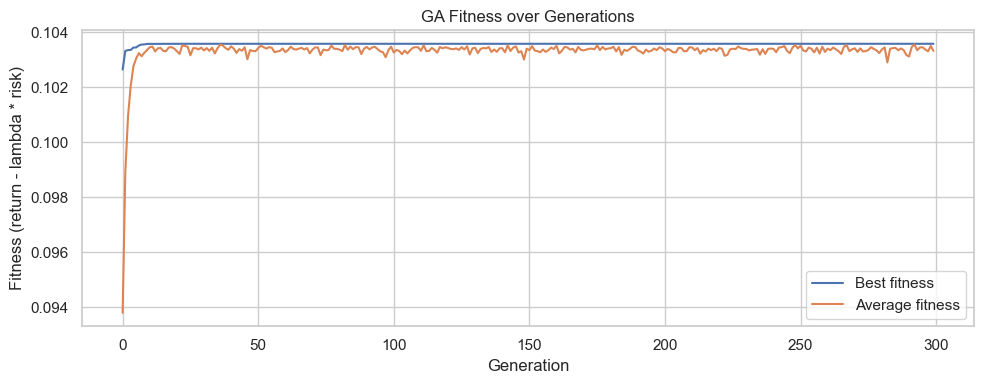

In [172]:

# Plot fitness history
plt.figure(figsize=(10,4))
plt.plot(best_history, label='Best fitness')
plt.plot(avg_history, label='Average fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness (return - lambda * risk)')
plt.title('GA Fitness over Generations')
plt.legend()
plt.tight_layout()

# Simpan ke file
fitness_path = os.path.join(OUTPUT_IMG_DIR, "fitness_plot.png")
plt.savefig(fitness_path, dpi=300, bbox_inches='tight')
print(f"✅ Fitness plot saved to {fitness_path}")

plt.show()


### 19. Perbandingan Portofolio Acak dan Hasil Algoritma Genetika  
Pada tahap ini dilakukan **evaluasi performa solusi GA** dengan membandingkannya terhadap ribuan portofolio acak.  

- **Random portfolios** dihasilkan dengan bobot acak (menggunakan distribusi Dirichlet agar total = 1).  
- Setiap portofolio dihitung **return rata-rata** dan **risikonya (standar deviasi)** berdasarkan kovarians aset.  
- Titik berwarna pada plot merepresentasikan portofolio acak dengan nilai objektif `return - λ*risk`.  
- Titik **merah** menunjukkan **portofolio terbaik hasil algoritma genetika**, yang seharusnya berada di area dengan rasio return terhadap risiko paling optimal.  

Visualisasi ini juga menggambarkan **Efficient Frontier** secara empiris — kurva yang menunjukkan kombinasi risiko-return terbaik.


✅ Efficient frontier plot saved to outputs\efficient_frontier.png


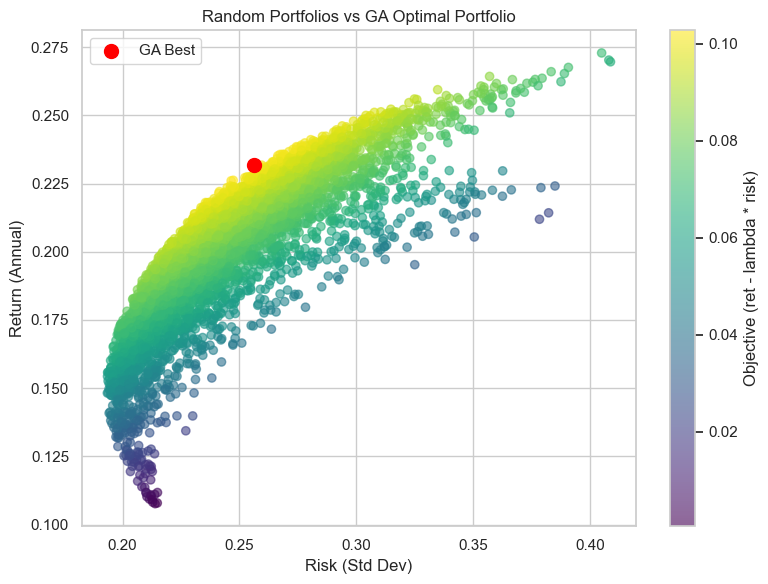

In [173]:

# Efficient Frontier
n_samples = 5000
rand_weights = np.random.dirichlet(np.ones(n_assets), n_samples)
rand_rets = np.array([np.dot(w, mean_returns.values) for w in rand_weights])
rand_risks = np.array([math.sqrt(np.dot(w.T, np.dot(cov_matrix.values, w))) for w in rand_weights])

plt.figure(figsize=(8,6))
sc = plt.scatter(rand_risks, rand_rets, c=(rand_rets - RISK_AVERSION*rand_risks), cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='Objective (ret - lambda * risk)')
plt.scatter([best_risk], [best_ret], color='red', s=100, label='GA Best')
plt.xlabel('Risk (Std Dev)')
plt.ylabel('Return (Annual)')
plt.title('Random Portfolios vs GA Optimal Portfolio')
plt.legend()
plt.tight_layout()

# Simpan ke file
frontier_path = os.path.join(OUTPUT_IMG_DIR, "efficient_frontier.png")
plt.savefig(frontier_path, dpi=300, bbox_inches='tight')
print(f"✅ Efficient frontier plot saved to {frontier_path}")

plt.show()

### 20. Menentukan Individu Terbaik dan Menyimpan Hasil  
Tahap ini memilih **kromosom dengan nilai fitness tertinggi**, yaitu kombinasi bobot saham paling optimal antara **return dan risiko**.  

- `fitness(ind)` digunakan untuk menilai seberapa baik setiap kromosom (portofolio).  
- `np.argmax()` memilih individu dengan nilai fitness maksimum.  
- Hasil terbaik disimpan dalam `result_df` yang berisi pasangan *Ticker* dan *Weight*.  
- Portofolio optimal juga disimpan ke file CSV (`best_portfolio_weights.csv`) agar dapat digunakan kembali di luar notebook.


In [174]:
# === Hasil terbaik ===
best_idx = np.argmax([fitness(ind) for ind in pop])
best_weights = pop[best_idx]
result_df = pd.DataFrame({'Ticker': TICKERS, 'Weight': best_weights.round(4)})

print("=== Portofolio Optimal ===")
print(result_df)
result_df.to_csv('best_portfolio_weights.csv', index=False)
print("\n✅ Saved best weights to best_portfolio_weights.csv")

=== Portofolio Optimal ===
    Ticker  Weight
0  ADRO.JK  0.2813
1  BBCA.JK  0.1748
2  ANTM.JK  0.0000
3  BBNI.JK  0.2263
4  PTBA.JK  0.3176

✅ Saved best weights to best_portfolio_weights.csv


### 21. Visualisasi Komposisi Portofolio (Pie Chart)  
Pie chart digunakan untuk menunjukkan **proporsi bobot tiap saham** dalam portofolio hasil optimasi genetika.  

- Setiap irisan merepresentasikan kontribusi saham terhadap total modal.  
- Parameter `explode` memberikan efek penonjolan pada saham dengan bobot positif yang dominan.  
- Visualisasi ini membantu memahami **diversifikasi portofolio** hasil GA.


✅ Portfolio pie chart saved to outputs\portfolio_pie.png


C:\Users\wahyu\AppData\Local\Temp\ipykernel_11444\3426777378.py:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\wahyu\AppData\Local\Temp\ipykernel_11444\3426777378.py:15: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig(pie_path, dpi=300, bbox_inches='tight')
C:\Users\wahyu\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


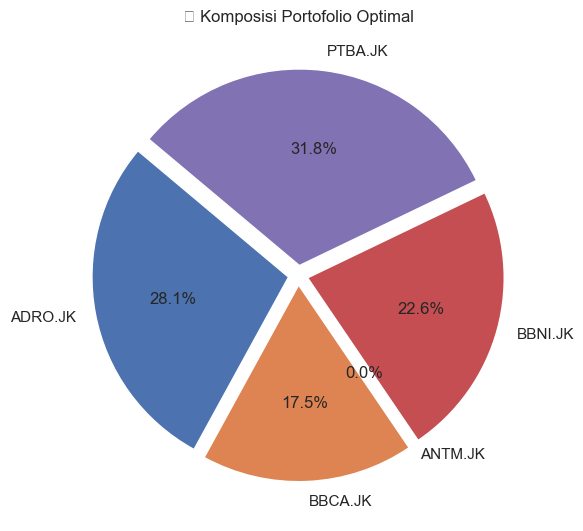

In [175]:
# Komposisi Portofolio Optimal (Pie Chart)
plt.figure(figsize=(6, 6))
plt.pie(
    result_df['Weight'],
    labels=result_df['Ticker'],
    autopct='%1.1f%%',
    startangle=140,
    explode=[0.05 if w > 0 else 0 for w in result_df['Weight']]
)
plt.title('📊 Komposisi Portofolio Optimal')
plt.tight_layout()

# Simpan ke file
pie_path = os.path.join(OUTPUT_IMG_DIR, "portfolio_pie.png")
plt.savefig(pie_path, dpi=300, bbox_inches='tight')
print(f"✅ Portfolio pie chart saved to {pie_path}")

plt.show()


### 22. Visualisasi Bobot Saham (Bar Chart)  
Bar chart memperlihatkan **nilai bobot setiap saham** secara kuantitatif.  

- Memudahkan analisis saham mana yang paling dominan dan mana yang memiliki porsi kecil.  
- Label di atas setiap batang menunjukkan nilai proporsi yang sudah dibulatkan.  
- Grafik ini sering digunakan untuk interpretasi hasil **seleksi akhir dalam algoritma genetika** pada konteks optimasi portofolio.


✅ Portfolio bar chart saved to outputs\portfolio_bar.png


C:\Users\wahyu\AppData\Local\Temp\ipykernel_11444\1758281773.py:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\wahyu\AppData\Local\Temp\ipykernel_11444\1758281773.py:17: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.savefig(bar_path, dpi=300, bbox_inches='tight')
C:\Users\wahyu\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


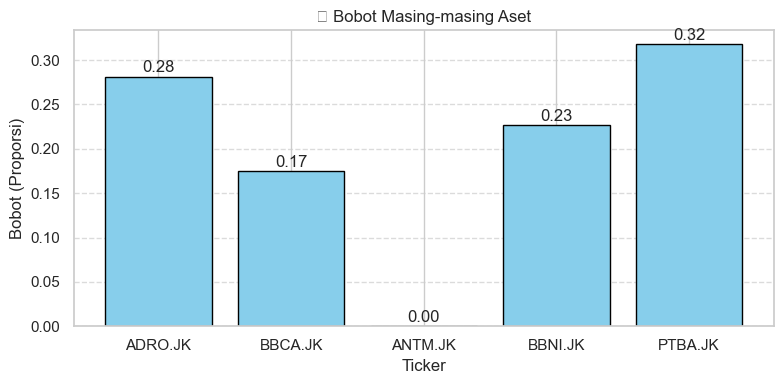

In [176]:
# Bobot Masing-masing Aset (Bar Chart)
plt.figure(figsize=(8, 4))
bars = plt.bar(result_df['Ticker'], result_df['Weight'], color='skyblue', edgecolor='black')
plt.title('📈 Bobot Masing-masing Aset')
plt.xlabel('Ticker')
plt.ylabel('Bobot (Proporsi)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.2f}", ha='center')

plt.tight_layout()

# Simpan ke file
bar_path = os.path.join(OUTPUT_IMG_DIR, "portfolio_bar.png")
plt.savefig(bar_path, dpi=300, bbox_inches='tight')
print(f"✅ Portfolio bar chart saved to {bar_path}")

plt.show()
